In [230]:
# %matplotlib inline
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')

In [231]:
raw_data = pd.read_csv("Online_Retail.csv")
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


In [232]:
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
print(sales_data.info())
sales_data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB
None


RangeIndex(start=0, stop=541909, step=1)

In [233]:
def extract_product(product_id,freq):
    #pull out all transactions of one product and drop StockCode
    product = sales_data.loc[sales_data['StockCode'] == product_id].drop('StockCode',axis=1)
    product=product.set_index(['InvoiceDate']) #Convert to timeseries 

    #DownSampling to a day
    day_summary = pd.DataFrame()
    day_summary['Quantity'] = product.Quantity.resample(freq).sum()
    day_summary = day_summary.fillna(0) #replacing NaN with 0
    day_summary = day_summary.clip(0) #replace -ve values with 0

    day_summary = day_summary['2010-12-12':]#trim as almost no data available before this date
    day_summary['Quantity']+=1#ti avoid -inf while taking log transformation 
    print(day_summary.describe())
    #plot
    fig, ax1 = plt.subplots()
    ax1.plot(day_summary.index, day_summary['Quantity'])
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity')
    # ax1.set_ylim(0,100)
    plt.show()
    return day_summary

         Quantity
count  364.000000
mean     6.483516
std     12.961790
min      1.000000
25%      1.000000
50%      2.000000
75%      7.000000
max    116.000000


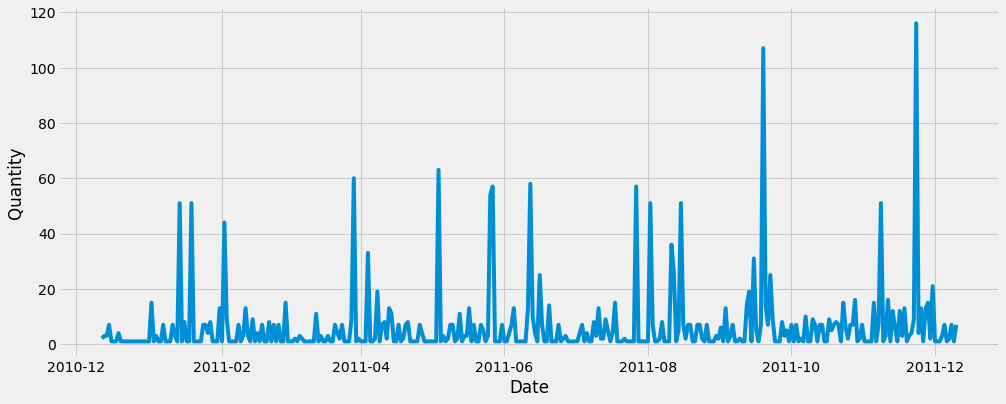

,Quantity
InvoiceDate,
2010-12-12,2.0
2010-12-13,3.0
2010-12-14,3.0
2010-12-15,7.0
2010-12-16,1.0


In [306]:
freq = 'D'
day_summary = extract_product('22899',freq)
day_summary.head()

In [307]:
#required by prophet
day_summary.reset_index(inplace=True)
day_summary = day_summary.rename(columns={'Quantity': 'y','InvoiceDate': 'ds'})
day_summary.head()

,ds,y
0,2010-12-12,2.0
1,2010-12-13,3.0
2,2010-12-14,3.0
3,2010-12-15,7.0
4,2010-12-16,1.0


In [308]:
train,test = day_summary[:-10],day_summary[-10:]

In [309]:
train.head()

,ds,y
0,2010-12-12,2.0
1,2010-12-13,3.0
2,2010-12-14,3.0
3,2010-12-15,7.0
4,2010-12-16,1.0


In [310]:
test.head()

,ds,y
354,2011-12-01,1.0
355,2011-12-02,1.0
356,2011-12-03,1.0
357,2011-12-04,3.0
358,2011-12-05,7.0


In [311]:
my_model = Prophet(daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True)

In [312]:
my_model.fit(train)

In [313]:
future_dates = my_model.make_future_dataframe(periods=10,freq=freq)
future_dates.tail()

,ds
359,2011-12-06
360,2011-12-07
361,2011-12-08
362,2011-12-09
363,2011-12-10


In [314]:
forecast = my_model.predict(future_dates)
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-12-12,1.302440,1.302440,1.302440,-13.843863,18.038763,-2.788218,-2.788218,-2.788218,0.874321,...,0.874321,0.874321,0.874321,-1.762821,-1.762821,-1.762821,5.425360,5.425360,5.425360,2.176761
1,2010-12-13,1.349196,1.349196,1.349196,-8.969680,21.059435,-2.788218,-2.788218,-2.788218,4.585767,...,4.585767,4.585767,4.585767,2.428859,2.428859,2.428859,4.945125,4.945125,4.945125,5.934963
2,2010-12-14,1.395952,1.395952,1.395952,-11.314084,20.081719,-2.788218,-2.788218,-2.788218,1.892762,...,1.892762,1.892762,1.892762,0.242348,0.242348,0.242348,4.438632,4.438632,4.438632,3.288713
3,2010-12-15,1.442708,1.442708,1.442708,-10.077191,22.034610,-2.788218,-2.788218,-2.788218,3.972680,...,3.972680,3.972680,3.972680,2.840620,2.840620,2.840620,3.920278,3.920278,3.920278,5.415387
4,2010-12-16,1.489463,1.489463,1.489463,-12.954041,18.950314,-2.788218,-2.788218,-2.788218,0.441685,...,0.441685,0.441685,0.441685,-0.174664,-0.174664,-0.174664,3.404567,3.404567,3.404567,1.931148


In [315]:
predicted = forecast[['ds', 'yhat']].tail(10)
predicted

,ds,yhat
354,2011-12-01,20.703135
355,2011-12-02,22.144568
356,2011-12-03,17.402192
357,2011-12-04,20.291807
358,2011-12-05,24.681477
359,2011-12-06,22.593564
360,2011-12-07,25.193103
361,2011-12-08,22.086044
362,2011-12-09,22.863248
363,2011-12-10,17.470402


In [316]:
test

,ds,y
354,2011-12-01,1.0
355,2011-12-02,1.0
356,2011-12-03,1.0
357,2011-12-04,3.0
358,2011-12-05,7.0
359,2011-12-06,1.0
360,2011-12-07,2.0
361,2011-12-08,7.0
362,2011-12-09,1.0
363,2011-12-10,7.0


In [319]:
np.sqrt(mean_squared_error(test.y,predicted.yhat))

18.802662262575126

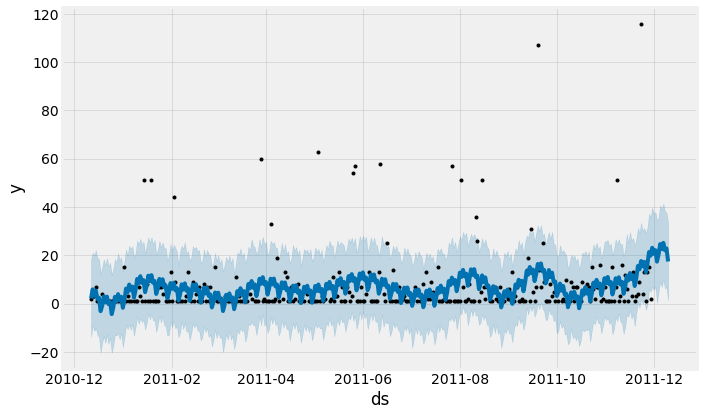

In [320]:
my_model.plot(forecast,uncertainty=True);

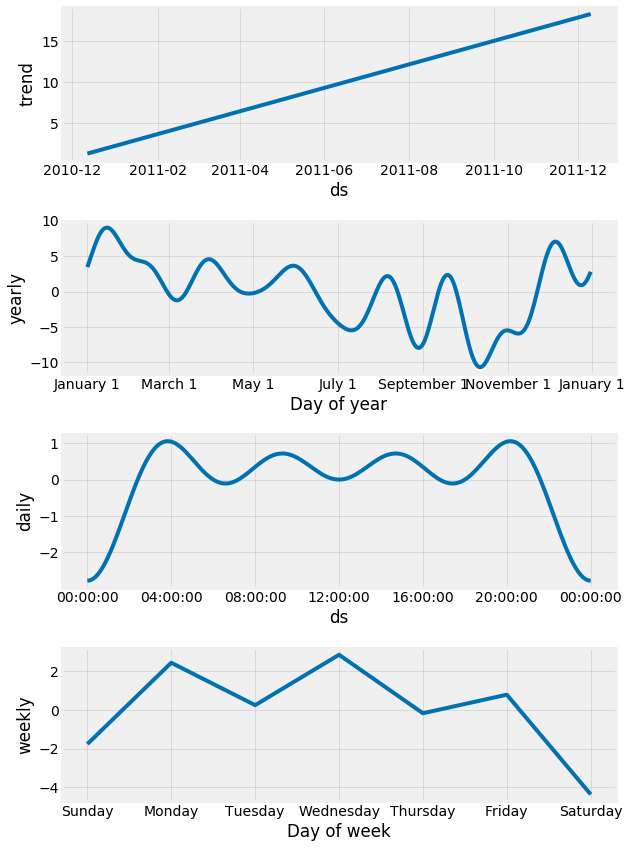

In [321]:
my_model.plot_components(forecast);